# Anac flight delay prediction

## Data Loading and Integration

This section loads the Brazilian ANAC VRA (Active Regular Flights) open dataset directly from the official data source.  
Monthly CSV files are dynamically retrieved for the selected year, validated for availability, and merged into a single DataFrame for further analysis.


In [ ]:
import pandas as pd
import requests
from urllib.parse import quote

# Base URL for ANAC open VRA (Active Regular Flights) dataset
BASE_URL = (
    "https://sistemas.anac.gov.br/dadosabertos/"
    "Voos%20e%20opera%C3%A7%C3%B5es%20a%C3%A9reas/"
    "Voo%20Regular%20Ativo%20%28VRA%29/"
)

# Month mapping required to match ANAC folder structure
MONTHS = {
    1: "Janeiro",
    2: "Fevereiro",
    3: "Março",
    4: "Abril",
    5: "Maio",
    6: "Junho",
    7: "Julho",
    8: "Agosto",
    9: "Setembro",
    10: "Outubro",
    11: "Novembro",
    12: "Dezembro",
}

# Years selected for analysis
YEARS = [2023,2024,2025]

dfs = []

def file_exists(url):
    """
    Check if a remote file exists before attempting download.
    This avoids runtime errors caused by missing monthly datasets.
    """
    try:
        r = requests.head(url, timeout=10)
        return r.status_code == 200
    except requests.RequestException:
        return False

# Download and load available monthly datasets
for year in YEARS:
    for month_num, month_name in MONTHS.items():

        folder = f"{month_num:02d} - {month_name}"
        filename = f"VRA_{year}{month_num}.csv"

        url = f"{BASE_URL}{year}/{quote(folder)}/{filename}"

        if not file_exists(url):
            print(f"❌ Missing: {year}-{month_num:02d}")
            continue

        print(f"✔️ Downloading {year}-{month_num:02d}")

        df = pd.read_csv(
            url,
            sep=";",
            encoding="utf-8",
            skiprows=1,
            low_memory=False
        )

        # Add explicit temporal identifiers for downstream analysis
        df["year"] = year
        df["month"] = month_num

        dfs.append(df)

# =========================
# FINAL MERGE
# =========================

# Combine all monthly datasets into a single DataFrame
df_final = pd.concat(dfs, ignore_index=True)

print("✅ All available VRA data merged")
print(df_final.shape)


✔️ Downloading 2023-01
✔️ Downloading 2023-02
✔️ Downloading 2023-03
✔️ Downloading 2023-04
✔️ Downloading 2023-05
✔️ Downloading 2023-06
✔️ Downloading 2023-07
✔️ Downloading 2023-08
✔️ Downloading 2023-09
✔️ Downloading 2023-10
✔️ Downloading 2023-11
✔️ Downloading 2023-12
✔️ Downloading 2024-01
✔️ Downloading 2024-02
✔️ Downloading 2024-03
✔️ Downloading 2024-04
✔️ Downloading 2024-05
✔️ Downloading 2024-06
✔️ Downloading 2024-07
✔️ Downloading 2024-08
✔️ Downloading 2024-09
✔️ Downloading 2024-10
✔️ Downloading 2024-11
✔️ Downloading 2024-12
✔️ Downloading 2025-01
✔️ Downloading 2025-02
✔️ Downloading 2025-03
✔️ Downloading 2025-04
✔️ Downloading 2025-05
✔️ Downloading 2025-06
✔️ Downloading 2025-07
✔️ Downloading 2025-08
✔️ Downloading 2025-09
✔️ Downloading 2025-10
✔️ Downloading 2025-11
✔️ Downloading 2025-12
✅ All available VRA data merged
(2975836, 14)


In [ ]:
df_final.to_parquet('vra_anac_2023_2025.parquet')

In [ ]:
url = 'https://raw.githubusercontent.com/JessePMelo/anac-flight-delay-prediction/main/data_science/data/processed/vra_anac_2023_2025.parquet'

df_final = pd.read_parquet(url)

After loading, all available monthly datasets are consolidated into a single DataFrame, preserving temporal identifiers (`year` and `month`) to support downstream feature engineering and exploratory analysis.


## Initial Dataset Inspection

After consolidating all available monthly files, an initial inspection is performed to understand the dataset structure, column availability, and basic integrity before proceeding with data preparation.


In [ ]:
df_final

,ICAO Empresa Aérea,Número Voo,Código Autorização (DI),Código Tipo Linha,ICAO Aeródromo Origem,ICAO Aeródromo Destino,Partida Prevista,Partida Real,Chegada Prevista,Chegada Real,Situação Voo,Código Justificativa,year,month
0,AZU,2913,0,N,SBFZ,SBRF,2023-01-24 05:40:00,2023-01-24 05:32:00,2023-01-24 07:00:00,2023-01-24 06:40:00,REALIZADO,NaN,2023,1
1,AZU,2913,0,N,SBFZ,SBRF,2023-01-25 05:40:00,2023-01-25 05:43:00,2023-01-25 07:00:00,2023-01-25 06:55:00,REALIZADO,NaN,2023,1
2,AZU,2913,0,N,SBFZ,SBRF,2023-01-26 05:40:00,2023-01-26 05:34:00,2023-01-26 07:00:00,2023-01-26 06:51:00,REALIZADO,NaN,2023,1
3,AZU,2913,0,N,SBFZ,SBRF,2023-01-27 05:40:00,2023-01-27 05:39:00,2023-01-27 07:00:00,2023-01-27 06:56:00,REALIZADO,NaN,2023,1
4,AZU,2913,0,N,SBFZ,SBRF,2023-01-28 05:40:00,2023-01-28 05:30:00,2023-01-28 07:00:00,2023-01-28 06:40:00,REALIZADO,NaN,2023,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2975831,TAM,9440,1,C,SBIL,SBGR,None,2025-12-31 16:12:00,None,2025-12-31 18:13:00,REALIZADO,NaN,2025,12
2975832,TPA,4057,2,X,SBEG,SKBO,None,2025-12-31 21:46:00,None,2026-01-01 00:24:00,REALIZADO,NaN,2025,12
2975833,TTL,5689,2,C,SBFL,SBPA,None,2025-12-31 05:20:00,None,2025-12-31 06:25:00,REALIZADO,NaN,2025,12
2975834,TTL,9900,6,C,SBRF,SBFZ,None,2025-12-31 09:10:00,None,2025-12-31 10:38:00,REALIZADO,NaN,2025,12


In [ ]:
anac_df = df_final.copy()

In [ ]:
anac_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2975836 entries, 0 to 2975835
Data columns (total 14 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   ICAO Empresa Aérea       object 
 1   Número Voo               object 
 2   Código Autorização (DI)  object 
 3   Código Tipo Linha        object 
 4   ICAO Aeródromo Origem    object 
 5   ICAO Aeródromo Destino   object 
 6   Partida Prevista         object 
 7   Partida Real             object 
 8   Chegada Prevista         object 
 9   Chegada Real             object 
 10  Situação Voo             object 
 11  Código Justificativa     float64
 12  year                     int64  
 13  month                    int64  
dtypes: float64(1), int64(2), object(11)
memory usage: 317.9+ MB


In [ ]:
anac_df.isna().sum()

,0
ICAO Empresa Aérea,0
Número Voo,0
Código Autorização (DI),0
Código Tipo Linha,474
ICAO Aeródromo Origem,0
ICAO Aeródromo Destino,0
Partida Prevista,96005
Partida Real,123846
Chegada Prevista,96007
Chegada Real,123846


## Missing Values Assessment

Before applying any transformations or filtering, missing values are evaluated to understand data completeness and identify columns that may require cleaning, imputation, or exclusion.


In [ ]:
anac_df.isna().sum()

,0
ICAO Empresa Aérea,0
Número Voo,0
Código Autorização (DI),0
Código Tipo Linha,474
ICAO Aeródromo Origem,0
ICAO Aeródromo Destino,0
Partida Prevista,96005
Partida Real,123846
Chegada Prevista,96007
Chegada Real,123846


The inspection shows that missing values are concentrated in a limited set of operational columns.  
These results guide subsequent filtering and cleaning decisions applied in the data preparation stage.


## Removal of Irrelevant and Non-Informative Columns

Some columns in the original dataset do not contribute to the delay prediction objective or are outside the scope of the current analysis. These fields are removed to reduce noise and simplify downstream processing.


In [ ]:
anac_df = anac_df.drop(columns=[
    'Código Autorização (DI)',
    'Código Tipo Linha',
    'Chegada Prevista',
    'Chegada Real',
    'Código Justificativa'
])


## Filtering Completed Flights

Only flights with status `REALIZADO` (completed flights) are retained for analysis.  
Canceled or non-completed flights are excluded, as departure delay cannot be reliably measured for these cases.


In [ ]:
anac_df = anac_df[anac_df['Situação Voo']=='REALIZADO']

In [ ]:
anac_df

,ICAO Empresa Aérea,Número Voo,ICAO Aeródromo Origem,ICAO Aeródromo Destino,Partida Prevista,Partida Real,Situação Voo,year,month
0,AZU,2913,SBFZ,SBRF,2023-01-24 05:40:00,2023-01-24 05:32:00,REALIZADO,2023,1
1,AZU,2913,SBFZ,SBRF,2023-01-25 05:40:00,2023-01-25 05:43:00,REALIZADO,2023,1
2,AZU,2913,SBFZ,SBRF,2023-01-26 05:40:00,2023-01-26 05:34:00,REALIZADO,2023,1
3,AZU,2913,SBFZ,SBRF,2023-01-27 05:40:00,2023-01-27 05:39:00,REALIZADO,2023,1
4,AZU,2913,SBFZ,SBRF,2023-01-28 05:40:00,2023-01-28 05:30:00,REALIZADO,2023,1
...,...,...,...,...,...,...,...,...,...
2975831,TAM,9440,SBIL,SBGR,None,2025-12-31 16:12:00,REALIZADO,2025,12
2975832,TPA,4057,SBEG,SKBO,None,2025-12-31 21:46:00,REALIZADO,2025,12
2975833,TTL,5689,SBFL,SBPA,None,2025-12-31 05:20:00,REALIZADO,2025,12
2975834,TTL,9900,SBRF,SBFZ,None,2025-12-31 09:10:00,REALIZADO,2025,12


This filtering step ensures consistency between the target variable definition and the operational scope of the dataset.


## Removal of Incomplete Records

Records containing missing values are removed to ensure data consistency and avoid introducing bias through artificial imputation.  
Given the operational nature of the dataset, incomplete records cannot be reliably corrected and are excluded from further analysis.


In [ ]:
anac_df = anac_df.dropna()

In [ ]:
anac_df

,ICAO Empresa Aérea,Número Voo,ICAO Aeródromo Origem,ICAO Aeródromo Destino,Partida Prevista,Partida Real,Situação Voo,year,month
0,AZU,2913,SBFZ,SBRF,2023-01-24 05:40:00,2023-01-24 05:32:00,REALIZADO,2023,1
1,AZU,2913,SBFZ,SBRF,2023-01-25 05:40:00,2023-01-25 05:43:00,REALIZADO,2023,1
2,AZU,2913,SBFZ,SBRF,2023-01-26 05:40:00,2023-01-26 05:34:00,REALIZADO,2023,1
3,AZU,2913,SBFZ,SBRF,2023-01-27 05:40:00,2023-01-27 05:39:00,REALIZADO,2023,1
4,AZU,2913,SBFZ,SBRF,2023-01-28 05:40:00,2023-01-28 05:30:00,REALIZADO,2023,1
...,...,...,...,...,...,...,...,...,...
2975753,ACA,0096,CYUL,SBGR,2025-12-20 22:55:00,2025-12-20 23:35:00,REALIZADO,2025,12
2975754,ACA,0096,CYUL,SBGR,2025-12-21 22:55:00,2025-12-21 22:59:00,REALIZADO,2025,12
2975755,ACA,0096,CYUL,SBGR,2025-12-22 22:55:00,2025-12-22 23:10:00,REALIZADO,2025,12
2975756,ACA,0096,CYUL,SBGR,2025-12-23 22:55:00,2025-12-23 23:04:00,REALIZADO,2025,12


In [ ]:
anac_df.isna().sum()

,0
ICAO Empresa Aérea,0
Número Voo,0
ICAO Aeródromo Origem,0
ICAO Aeródromo Destino,0
Partida Prevista,0
Partida Real,0
Situação Voo,0
year,0
month,0


This step results in a clean dataset where all remaining records contain the minimum required information for delay calculation and feature engineering.


## Data Type Standardization

Data types are explicitly standardized to ensure semantic correctness, memory efficiency, and compatibility with downstream feature engineering and modeling steps.


In [ ]:
# Create an explicit copy to avoid chained assignment issues
anac_df = anac_df.copy()

# Columns representing identifiers and categorical attributes
category_cols = [
    'ICAO Empresa Aérea',
    'Número Voo',
    'ICAO Aeródromo Origem',
    'ICAO Aeródromo Destino',
    'Situação Voo'
]

# Cast categorical features to pandas 'category' dtype
anac_df[category_cols] = anac_df[category_cols].astype('category')

# Datetime columns used for delay calculation and temporal feature extraction
datetime_cols = [
    'Partida Prevista',
    'Partida Real'
]


Explicit type casting ensures consistent behavior across the data preparation pipeline and prevents ambiguity during feature extraction and modeling.


In [ ]:
anac_df[category_cols] = anac_df[category_cols].astype('category')

In [ ]:
anac_df[datetime_cols] = anac_df[datetime_cols].apply(
    pd.to_datetime,
    dayfirst=True,
    errors='coerce'
)

/tmp/ipython-input-3052966532.py:1: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  anac_df[datetime_cols] = anac_df[datetime_cols].apply(
/tmp/ipython-input-3052966532.py:1: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  anac_df[datetime_cols] = anac_df[datetime_cols].apply(


In [ ]:
anac_df['year'] = anac_df['year'].astype('int16')
anac_df['month'] = anac_df['month'].astype('int8')

In [ ]:
anac_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2755985 entries, 0 to 2975757
Data columns (total 9 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   ICAO Empresa Aérea      category      
 1   Número Voo              category      
 2   ICAO Aeródromo Origem   category      
 3   ICAO Aeródromo Destino  category      
 4   Partida Prevista        datetime64[ns]
 5   Partida Real            datetime64[ns]
 6   Situação Voo            category      
 7   year                    int16         
 8   month                   int8          
dtypes: category(5), datetime64[ns](2), int16(1), int8(1)
memory usage: 95.0 MB


## Departure Delay Calculation

The departure delay is computed as the difference between the actual and scheduled departure times.  
This continuous variable represents the foundation for defining the target variable and supports both exploratory analysis and feature engineering.


In [ ]:
anac_df['delay_minutes'] = (
    anac_df['Partida Real'] - anac_df['Partida Prevista']
).dt.total_seconds() / 60


Positive values indicate delayed departures, while negative values represent early departures.  
This feature is used exclusively for target definition and exploratory analysis and is excluded from the modeling feature set to prevent data leakage.


## Target Variable Definition

A binary target variable is defined based on a delay threshold of 15 minutes.  
Flights departing more than 15 minutes after the scheduled time are labeled as delayed.


In [ ]:
anac_df['is_delayed'] = (anac_df['delay_minutes'] > 15).astype('int8')

This binary formulation enables the use of classification models such as logistic regression, while maintaining interpretability and alignment with common operational delay definitions.


## Day of Week Extraction

The day of the week is extracted from the scheduled departure time to capture weekly operational patterns that may influence flight delays.


In [ ]:
anac_df

,ICAO Empresa Aérea,Número Voo,ICAO Aeródromo Origem,ICAO Aeródromo Destino,Partida Prevista,Partida Real,Situação Voo,year,month,delay_minutes,is_delayed
0,AZU,2913,SBFZ,SBRF,2023-01-24 05:40:00,2023-01-24 05:32:00,REALIZADO,2023,1,-8.0,0
1,AZU,2913,SBFZ,SBRF,2023-01-25 05:40:00,2023-01-25 05:43:00,REALIZADO,2023,1,3.0,0
2,AZU,2913,SBFZ,SBRF,2023-01-26 05:40:00,2023-01-26 05:34:00,REALIZADO,2023,1,-6.0,0
3,AZU,2913,SBFZ,SBRF,2023-01-27 05:40:00,2023-01-27 05:39:00,REALIZADO,2023,1,-1.0,0
4,AZU,2913,SBFZ,SBRF,2023-01-28 05:40:00,2023-01-28 05:30:00,REALIZADO,2023,1,-10.0,0
...,...,...,...,...,...,...,...,...,...,...,...
2975753,ACA,0096,CYUL,SBGR,2025-12-20 22:55:00,2025-12-20 23:35:00,REALIZADO,2025,12,40.0,1
2975754,ACA,0096,CYUL,SBGR,2025-12-21 22:55:00,2025-12-21 22:59:00,REALIZADO,2025,12,4.0,0
2975755,ACA,0096,CYUL,SBGR,2025-12-22 22:55:00,2025-12-22 23:10:00,REALIZADO,2025,12,15.0,0
2975756,ACA,0096,CYUL,SBGR,2025-12-23 22:55:00,2025-12-23 23:04:00,REALIZADO,2025,12,9.0,0


In [ ]:
anac_df['day_of_week'] = (
    anac_df['Partida Real']
    .dt.dayofweek
    .astype('Int8')
)


The feature ranges from 0 (Monday) to 6 (Sunday) and allows the model to learn differences in delay behavior across weekdays and weekends.


## Temporal Feature Engineering

Multiple calendar-based features are derived from the scheduled departure time to capture seasonal, weekly, and intraday patterns associated with flight delays.


In [ ]:
anac_df['week_of_year'] = (
    anac_df['Partida Real']
    .dt.isocalendar()
    .week
    .astype('Int8')
)


In [ ]:
anac_df['week_of_month'] = (
    ((anac_df['Partida Real'].dt.day - 1) // 7 + 1)
    .astype('Int8')
)


In [ ]:
anac_df['hour'] = (
    anac_df['Partida Real']
    .dt.hour
    .astype('Int8')
)


In [ ]:
anac_df['is_weekend'] = (
    anac_df['day_of_week'] >= 5
).astype('Int8')


In [ ]:
anac_df['day_of_year'] = (
    anac_df['Partida Real']
    .dt.dayofyear
    .astype('Int16')
)


In [ ]:
import pandas as pd
import holidays

# Garantir datetime
anac_df['Partida Prevista'] = pd.to_datetime(anac_df['Partida Prevista'])

# Normalizar (zera hora, mantém datetime)
anac_df['date'] = anac_df['Partida Prevista'].dt.normalize()

# Criar calendário de feriados
br_holidays = holidays.Brazil()

# Converter feriados para DatetimeIndex normalizado
holiday_dates = pd.to_datetime(list(br_holidays.keys()))

# ------------------------
# Features
# ------------------------

# Feriado
anac_df['is_holiday'] = anac_df['date'].isin(holiday_dates).astype('Int8')

# Pré-feriado (dia antes do feriado)
anac_df['is_pre_holiday'] = (
    (anac_df['date'] + pd.Timedelta(days=1))
    .isin(holiday_dates)
    .astype('Int8')
)

# Pós-feriado (dia depois do feriado)
anac_df['is_post_holiday'] = (
    (anac_df['date'] - pd.Timedelta(days=1))
    .isin(holiday_dates)
    .astype('Int8')
)



In [ ]:
anac_df

,ICAO Empresa Aérea,Número Voo,ICAO Aeródromo Origem,ICAO Aeródromo Destino,Partida Prevista,Partida Real,Situação Voo,year,month,delay_minutes,...,day_of_week,week_of_year,week_of_month,hour,is_weekend,day_of_year,date,is_holiday,is_pre_holiday,is_post_holiday
0,AZU,2913,SBFZ,SBRF,2023-01-24 05:40:00,2023-01-24 05:32:00,REALIZADO,2023,1,-8.0,...,1,4,4,5,0,24,2023-01-24,0,0,0
1,AZU,2913,SBFZ,SBRF,2023-01-25 05:40:00,2023-01-25 05:43:00,REALIZADO,2023,1,3.0,...,2,4,4,5,0,25,2023-01-25,0,0,0
2,AZU,2913,SBFZ,SBRF,2023-01-26 05:40:00,2023-01-26 05:34:00,REALIZADO,2023,1,-6.0,...,3,4,4,5,0,26,2023-01-26,0,0,0
3,AZU,2913,SBFZ,SBRF,2023-01-27 05:40:00,2023-01-27 05:39:00,REALIZADO,2023,1,-1.0,...,4,4,4,5,0,27,2023-01-27,0,0,0
4,AZU,2913,SBFZ,SBRF,2023-01-28 05:40:00,2023-01-28 05:30:00,REALIZADO,2023,1,-10.0,...,5,4,4,5,1,28,2023-01-28,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2975753,ACA,0096,CYUL,SBGR,2025-12-20 22:55:00,2025-12-20 23:35:00,REALIZADO,2025,12,40.0,...,5,51,3,23,1,354,2025-12-20,0,0,0
2975754,ACA,0096,CYUL,SBGR,2025-12-21 22:55:00,2025-12-21 22:59:00,REALIZADO,2025,12,4.0,...,6,51,3,22,1,355,2025-12-21,0,0,0
2975755,ACA,0096,CYUL,SBGR,2025-12-22 22:55:00,2025-12-22 23:10:00,REALIZADO,2025,12,15.0,...,0,52,4,23,0,356,2025-12-22,0,0,0
2975756,ACA,0096,CYUL,SBGR,2025-12-23 22:55:00,2025-12-23 23:04:00,REALIZADO,2025,12,9.0,...,1,52,4,23,0,357,2025-12-23,0,0,0


All temporal features are extracted exclusively from scheduled departure times to avoid information leakage and ensure model validity.


## Removal of Leakage-Prone and Non-Modeling Features

Columns that either introduce data leakage or are no longer required after feature extraction are removed to ensure a clean, model-ready dataset.


In [ ]:
cols_to_drop = [
    'Partida Prevista',
    'Partida Real',
    'delay_minutes',
    'Situação Voo',
    'date'
]

anac_df = anac_df.drop(columns=cols_to_drop)


After this step, the dataset contains only features available at prediction time, fully aligned with the modeling objective.


## Final Dataset Validation

A final inspection is performed to confirm data integrity, data types, and overall readiness for modeling.


In [ ]:
anac_df

,ICAO Empresa Aérea,Número Voo,ICAO Aeródromo Origem,ICAO Aeródromo Destino,year,month,is_delayed,day_of_week,week_of_year,week_of_month,hour,is_weekend,day_of_year,is_holiday,is_pre_holiday,is_post_holiday
0,AZU,2913,SBFZ,SBRF,2023,1,0,1,4,4,5,0,24,0,0,0
1,AZU,2913,SBFZ,SBRF,2023,1,0,2,4,4,5,0,25,0,0,0
2,AZU,2913,SBFZ,SBRF,2023,1,0,3,4,4,5,0,26,0,0,0
3,AZU,2913,SBFZ,SBRF,2023,1,0,4,4,4,5,0,27,0,0,0
4,AZU,2913,SBFZ,SBRF,2023,1,0,5,4,4,5,1,28,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2975753,ACA,0096,CYUL,SBGR,2025,12,1,5,51,3,23,1,354,0,0,0
2975754,ACA,0096,CYUL,SBGR,2025,12,0,6,51,3,22,1,355,0,0,0
2975755,ACA,0096,CYUL,SBGR,2025,12,0,0,52,4,23,0,356,0,0,0
2975756,ACA,0096,CYUL,SBGR,2025,12,0,1,52,4,23,0,357,0,0,0


In [ ]:
anac_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2755985 entries, 0 to 2975757
Data columns (total 16 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   ICAO Empresa Aérea      category
 1   Número Voo              category
 2   ICAO Aeródromo Origem   category
 3   ICAO Aeródromo Destino  category
 4   year                    int16   
 5   month                   int8    
 6   is_delayed              int8    
 7   day_of_week             Int8    
 8   week_of_year            Int8    
 9   week_of_month           Int8    
 10  hour                    Int8    
 11  is_weekend              Int8    
 12  day_of_year             Int16   
 13  is_holiday              Int8    
 14  is_pre_holiday          Int8    
 15  is_post_holiday         Int8    
dtypes: Int16(1), Int8(8), category(4), int16(1), int8(2)
memory usage: 102.8 MB


The inspection confirms that the dataset contains no missing values or leakage-prone features and is fully structured for machine learning workflows.


## Exploratory Analysis: Target Distribution

This analysis examines the distribution of the target variable to assess class balance and establish a baseline understanding of flight delays in the dataset.


In [ ]:
anac_df['is_delayed'].value_counts(normalize=True)


,proportion
is_delayed,
0,0.829484
1,0.170516


The results indicate that delayed flights represent a minority of the observations, suggesting a moderately imbalanced classification problem.  
This imbalance highlights the importance of using evaluation metrics beyond accuracy, such as recall and precision, during model assessment.


## Exploratory Analysis: Delay by Hour of Day

This analysis evaluates how the probability of flight delays varies throughout the day, aiming to identify intraday operational patterns.


In [ ]:
anac_df.groupby('hour', observed=True)['is_delayed'].mean().sort_values(ascending=False)


,is_delayed
hour,
0,0.343965
23,0.242701
18,0.241113
22,0.229862
19,0.226092
20,0.225242
21,0.221591
1,0.204700
15,0.202367


Flights scheduled during later hours of the day show a higher probability of delay.  
This pattern suggests cumulative operational effects, where delays propagate throughout the day as aircraft rotations and airport congestion increase.


## Exploratory Analysis: Delay by Day of Week

This analysis examines how delay probabilities vary across the days of the week, capturing potential weekly operational patterns.


In [ ]:
anac_df.groupby('day_of_week', observed=True)['is_delayed'].mean()


,is_delayed
day_of_week,
0,0.168587
1,0.162259
2,0.172468
3,0.188747
4,0.197004
5,0.151897
6,0.148650


The results suggest that delay behavior varies across weekdays, with some days exhibiting higher delay probabilities.  
This reinforces the relevance of weekly temporal patterns in flight delay prediction.


## Exploratory Analysis: Delay by Airline

This analysis evaluates how delay probabilities vary across airlines, highlighting potential differences in operational performance.


In [ ]:
anac_df.groupby(
    'ICAO Empresa Aérea',
    observed=True
)['is_delayed'].mean().sort_values(ascending=False)


,is_delayed
ICAO Empresa Aérea,
WFL,1.0
MSR,1.0
KAI,1.0
SVA,1.0
PUE,1.0
...,...
MMZ,0.0
MLM,0.0
TVS,0.0


Significant variation in delay rates is observed across airlines.  
However, extreme values may be associated with carriers that operate a small number of flights, requiring cautious interpretation.


## Exploratory Analysis: Delay by Origin Airport

This analysis investigates how delay probabilities vary across origin aerodromes, aiming to identify potential operational bottlenecks at departure airports.


In [ ]:
anac_df.groupby(
    'ICAO Aeródromo Origem',
    observed=True
)['is_delayed'].mean().sort_values(ascending=False)


,is_delayed
ICAO Aeródromo Origem,
FTTJ,1.0
CYXX,1.0
SVVG,1.0
KAUS,1.0
SVMC,1.0
...,...
GCFV,0.0
FNBJ,0.0
FYWH,0.0


Large differences in delay rates are observed across origin airports.  
However, extreme delay probabilities are often associated with aerodromes with very low flight volumes and should be interpreted with caution.


## Exploratory Analysis: Delay Rate and Flight Volume by Origin Airport

To avoid misleading interpretations driven by small sample sizes, delay rates are analyzed together with the number of flights per origin airport.


In [ ]:
airport_stats = (
    anac_df
    .groupby('ICAO Aeródromo Origem', observed=True)
    .agg(
        delay_rate=('is_delayed', 'mean'),
        flights=('is_delayed', 'count')
    )
    .sort_values('delay_rate', ascending=False)
)

airport_stats


,delay_rate,flights
ICAO Aeródromo Origem,,
FTTJ,1.0,1
CYXX,1.0,1
SVVG,1.0,2
KAUS,1.0,1
SVMC,1.0,1
...,...,...
GCFV,0.0,1
FNBJ,0.0,41
FYWH,0.0,1


Airports with extreme delay rates often correspond to very low flight volumes, indicating that sample size plays a critical role in interpreting operational performance.  
Airports with both high delay rates and substantial flight volumes are more indicative of systemic constraints.


## Summary of EDA Insights

- Delayed flights represent a minority of the dataset, indicating a moderately imbalanced classification problem and reinforcing the need for recall-focused evaluation metrics.
- Delay probability increases throughout the day, with later scheduled departures exhibiting higher delay rates, suggesting cumulative operational effects.
- Weekly temporal patterns are observed, with delay behavior varying across days of the week.
- Significant variability exists across airlines and origin airports; however, extreme delay rates are often associated with low flight volumes and should be interpreted cautiously.
- Temporal and operational features derived from scheduled departure times appear to be relevant predictors for flight delay classification.


#RECOMENDAR DAQUI PARA BAIXO !

##CORR

In [ ]:
anac_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2755985 entries, 0 to 2975757
Data columns (total 16 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   ICAO Empresa Aérea      category
 1   Número Voo              category
 2   ICAO Aeródromo Origem   category
 3   ICAO Aeródromo Destino  category
 4   year                    int16   
 5   month                   int8    
 6   is_delayed              int8    
 7   day_of_week             Int8    
 8   week_of_year            Int8    
 9   week_of_month           Int8    
 10  hour                    Int8    
 11  is_weekend              Int8    
 12  day_of_year             Int16   
 13  is_holiday              Int8    
 14  is_pre_holiday          Int8    
 15  is_post_holiday         Int8    
dtypes: Int16(1), Int8(8), category(4), int16(1), int8(2)
memory usage: 102.8 MB


In [ ]:
colunas_numericas = [
    'month', 'is_delayed',
    'day_of_week', 'week_of_year',
    'week_of_month', 'hour',
    'is_weekend', 'day_of_year',



]

df_corr = anac_df[colunas_numericas]

corr_target = (
    df_corr
    .drop(columns='is_delayed')
    .corrwith(df_corr['is_delayed'])
    .sort_values(ascending=False)
)

corr_target



,0
hour,0.104278
week_of_year,0.040717
day_of_year,0.039622
month,0.039350
week_of_month,0.000310
day_of_week,-0.009160
is_weekend,-0.032386


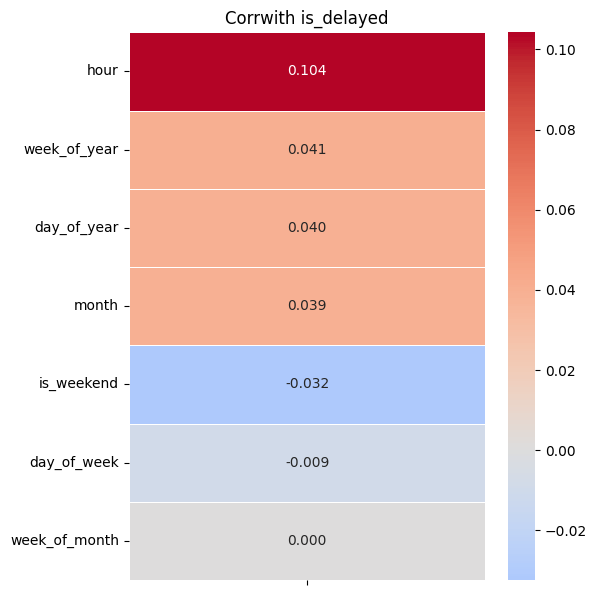

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


corr_target = (
    df_corr
    .drop(columns='is_delayed')
    .corrwith(df_corr['is_delayed'])
    .reindex(
        df_corr.drop(columns='is_delayed')
        .corrwith(df_corr['is_delayed'])
        .abs()
        .sort_values(ascending=False)
        .index
    )
)

corr_target_df = corr_target.to_frame(name='')

plt.figure(figsize=(6,6))

sns.heatmap(
    corr_target_df,
    annot=True,
    fmt=".3f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5
)

plt.title('Corrwith is_delayed', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



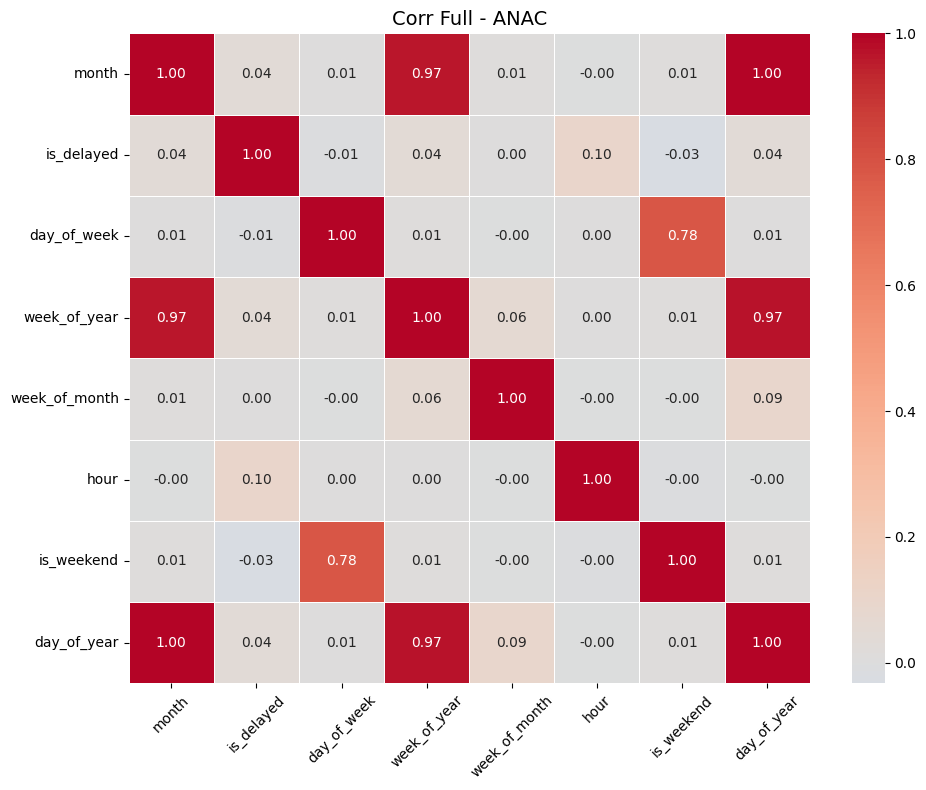

In [ ]:
colunas_numericas = [
    'month', 'is_delayed',
    'day_of_week', 'week_of_year',
    'week_of_month', 'hour',
    'is_weekend', 'day_of_year'
]

df_corr = anac_df[colunas_numericas]

corr_matrix = df_corr.corr()

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,8))

sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5
)

plt.title("Corr Full - ANAC", fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



## VIF

In [ ]:
anac_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2755985 entries, 0 to 2975757
Data columns (total 16 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   ICAO Empresa Aérea      category
 1   Número Voo              category
 2   ICAO Aeródromo Origem   category
 3   ICAO Aeródromo Destino  category
 4   year                    int16   
 5   month                   int8    
 6   is_delayed              int8    
 7   day_of_week             Int8    
 8   week_of_year            Int8    
 9   week_of_month           Int8    
 10  hour                    Int8    
 11  is_weekend              Int8    
 12  day_of_year             Int16   
 13  is_holiday              Int8    
 14  is_pre_holiday          Int8    
 15  is_post_holiday         Int8    
dtypes: Int16(1), Int8(8), category(4), int16(1), int8(2)
memory usage: 102.8 MB


In [ ]:
features_for_vif = [
    'day_of_week',
    'week_of_year',
    'hour',
    'is_weekend',

]

In [ ]:
X = anac_df[features_for_vif].dropna()
X = X.astype('float64')

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

vif = pd.DataFrame()
vif["feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i)
              for i in range(X.shape[1])]

vif = vif.sort_values("VIF", ascending=False)

vif


,feature,VIF
0,day_of_week,6.377341
2,hour,3.428506
3,is_weekend,3.259361
1,week_of_year,3.017678


## Train and Test Dataset Definition

The dataset is prepared for modeling by explicitly separating features and target variables and defining training and test sets.  
This step ensures a clear and reproducible evaluation workflow, preventing data leakage between model training and performance assessment.


In [ ]:
rename_map = {
    'ICAO Empresa Aérea': 'airline',
    'Número Voo': 'flight_number',
    'ICAO Aeródromo Origem': 'origin_airport',
    'ICAO Aeródromo Destino': 'destination_airport',
}

model_df = anac_df.rename(columns=rename_map)


In [ ]:
columns = [
    'airline',
    'flight_number',
    'origin_airport',
    'destination_airport',
    'day_of_week',
    'hour',
    'is_weekend',
    'week_of_year',
    'is_delayed',
    'is_holiday',
    'is_pre_holiday',
    'is_post_holiday',
    'year'

]

model_df = model_df[columns].copy()

In [ ]:
model_df.to_parquet('model_df_clean.parquet')

In [3]:
import pandas as pd

url = 'https://raw.githubusercontent.com/JessePMelo/anac-flight-delay-prediction/main/data_science/data/processed/model_df_clean.parquet'

model_df = pd.read_parquet(url)

In [9]:
top_flights = (
    model_df['flight_number']
    .value_counts()
    .head(1000)
    .index
)

model_df['flight_number'] = model_df['flight_number'].apply(
    lambda x: x if x in top_flights else 'OTHER'
)


In [10]:
model_df.head()

,airline,flight_number,origin_airport,destination_airport,day_of_week,hour,is_weekend,week_of_year,is_delayed,is_holiday,is_pre_holiday,is_post_holiday,year
0,AZU,2913,SBFZ,SBRF,1,5,0,4,0,0,0,0,2023
1,AZU,2913,SBFZ,SBRF,2,5,0,4,0,0,0,0,2023
2,AZU,2913,SBFZ,SBRF,3,5,0,4,0,0,0,0,2023
3,AZU,2913,SBFZ,SBRF,4,5,0,4,0,0,0,0,2023
4,AZU,2913,SBFZ,SBRF,5,5,1,4,0,0,0,0,2023


In [11]:
model_df['flight_number'].nunique()

1001

In [15]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2755985 entries, 0 to 2975757
Data columns (total 13 columns):
 #   Column               Dtype   
---  ------               -----   
 0   airline              category
 1   flight_number        category
 2   origin_airport       category
 3   destination_airport  category
 4   day_of_week          float64 
 5   hour                 float64 
 6   is_weekend           Int8    
 7   week_of_year         float64 
 8   is_delayed           int8    
 9   is_holiday           Int8    
 10  is_pre_holiday       Int8    
 11  is_post_holiday      Int8    
 12  year                 float64 
dtypes: Int8(4), category(4), float64(4), int8(1)
memory usage: 149.9 MB


In [12]:
categorical_cols = [
    'airline',
    'flight_number',
    'origin_airport',
    'destination_airport'
]

binary_cols = [
    'is_weekend',
    'is_holiday',
    'is_pre_holiday',
    'is_post_holiday'
]

continuous_cols = [
    'day_of_week',
    'hour',
    'week_of_year',
    'year'
]


In [14]:
for col in categorical_cols:
    model_df[col] = model_df[col].astype('category')

for col in continuous_cols:
    model_df[col] = model_df[col].astype(float)

In [16]:

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

preprocessor = ColumnTransformer(
    transformers=[
        ('cont', StandardScaler(), continuous_cols),
        ('bin', 'passthrough', binary_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        penalty='l2',
        C=0.5,
        solver='saga',          # Melhor para muitos dados + sparse
        max_iter=500,           # 1000 é desnecessário na maioria dos casos
        class_weight='balanced',
        n_jobs=-1,              # Usa todos os núcleos
        random_state=42
    ))
])

In [19]:

train = model_df[model_df['year'].isin([2023, 2024])].copy()
test  = model_df[model_df['year'] == 2025].copy()

X_train = train.drop(columns=['is_delayed'])
y_train = train['is_delayed']

X_test = test.drop(columns=['is_delayed'])
y_test = test['is_delayed']

In [20]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cont', StandardScaler(),
                                                  ['day_of_week', 'hour',
                                                   'week_of_year', 'year']),
                                                 ('bin', 'passthrough',
                                                  ['is_weekend', 'is_holiday',
                                                   'is_pre_holiday',
                                                   'is_post_holiday']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['airline', 'flight_number',
                                                   'origin_airport',
                                                   'destination_airport'])])),
                ('classifier',
                 LogisticRegression(C=0.5, class_weight='balanced',
                                    max_iter=500, n_jobs=-1, random_state=42,
                                    solver='saga'))])

In [21]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]


In [22]:
from sklearn.metrics import classification_report, roc_auc_score

print(classification_report(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.89      0.67      0.76    805788
           1       0.21      0.51      0.30    143020

    accuracy                           0.64    948808
   macro avg       0.55      0.59      0.53    948808
weighted avg       0.78      0.64      0.69    948808

AUC: 0.6237533375565608


In [23]:

import numpy as np
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

for i in range(0, len(thresholds), len(thresholds)//10):
    print(f"Threshold: {thresholds[i]:.3f} | Precision: {precision[i]:.3f} | Recall: {recall[i]:.3f}")


Threshold: 0.018 | Precision: 0.151 | Recall: 1.000
Threshold: 0.285 | Precision: 0.159 | Recall: 0.950
Threshold: 0.340 | Precision: 0.167 | Recall: 0.890
Threshold: 0.381 | Precision: 0.177 | Recall: 0.823
Threshold: 0.417 | Precision: 0.187 | Recall: 0.747
Threshold: 0.451 | Precision: 0.198 | Recall: 0.658
Threshold: 0.486 | Precision: 0.210 | Recall: 0.557
Threshold: 0.523 | Precision: 0.222 | Recall: 0.441
Threshold: 0.567 | Precision: 0.236 | Recall: 0.312
Threshold: 0.639 | Precision: 0.247 | Recall: 0.163
Threshold: 0.987 | Precision: 0.000 | Recall: 0.000


In [24]:
best_threshold = 0.451


In [25]:
y_pred_custom = (y_proba >= best_threshold).astype(int)
print(classification_report(y_test, y_pred_custom))


              precision    recall  f1-score   support

           0       0.90      0.53      0.66    805788
           1       0.20      0.66      0.30    143020

    accuracy                           0.55    948808
   macro avg       0.55      0.59      0.48    948808
weighted avg       0.79      0.55      0.61    948808

